In [ ]:
!pip install -q -U google-generativeai

In [ ]:
import pandas as pd
df = pd.read_parquet("train-00000-of-00001-a5a7c6e4bb30b016.parquet")

In [ ]:
# prompt: convert this parquet file to a csv file and we work from there

import pandas as pd

# Assuming 'train-00000-of-00001-a5a7c6e4bb30b016.parquet' is in your current directory
# Replace with the actual path if needed.
df = pd.read_parquet("train-00000-of-00001-a5a7c6e4bb30b016.parquet")

# Convert the DataFrame to a CSV file
df.to_csv("output.csv", index=False)  # index=False prevents writing row indices to the CSV

In [ ]:
df.head()

,issue_area,issue_category,issue_sub_category,issue_category_sub_category,customer_sentiment,product_category,product_sub_category,issue_complexity,agent_experience_level,agent_experience_level_desc,conversation
0,Login and Account,Mobile Number and Email Verification,Verification requirement for mobile number or ...,Mobile Number and Email Verification -> Verifi...,neutral,Appliances,Oven Toaster Grills (OTG),medium,junior,"handles customer inquiries independently, poss...",Agent: Thank you for calling BrownBox Customer...
1,Cancellations and returns,Pickup and Shipping,Reasons for being asked to ship the item,Pickup and Shipping -> Reasons for being asked...,neutral,Electronics,Computer Monitor,less,junior,"handles customer inquiries independently, poss...",Agent: Thank you for calling BrownBox customer...
2,Cancellations and returns,Replacement and Return Process,Inability to click the 'Cancel' button,Replacement and Return Process -> Inability to...,neutral,Appliances,Juicer/Mixer/Grinder,medium,experienced,"confidently handles complex customer issues, e...",Agent: Thank you for calling BrownBox Customer...
3,Login and Account,Login Issues and Error Messages,Error message regarding exceeded attempts to e...,Login Issues and Error Messages -> Error messa...,neutral,Appliances,Water Purifier,less,inexperienced,"may struggle with ambiguous queries, rely on c...","Customer: Hi, I am facing an issue while loggi..."
4,Order,Order Delivery Issues,Delivery not attempted again,Order Delivery Issues -> Delivery not attempte...,negative,Electronics,Bp Monitor,medium,experienced,"confidently handles complex customer issues, e...",Agent: Thank you for contacting BrownBox custo...


In [ ]:
# prompt: search for only "positive" customer_sentiment and generate the df table and tell how many rows they are

positive_df = df[df['customer_sentiment'] == 'positive']
print(positive_df)
print(f"Number of rows with positive customer sentiment: {len(positive_df)}")

    issue_area                 issue_category  \
65       Order   Product Information and Tags   
147      Order               Placing an Order   
184      Order  Order Confirmation and Status   
187      Order   Product Information and Tags   
256      Order   Product Information and Tags   
267      Order               Placing an Order   
268      Order  Order Confirmation and Status   
333      Order   Product Information and Tags   
429      Order  Order Confirmation and Status   
446      Order               Placing an Order   
454      Order  Order Confirmation and Status   
470      Order  Order Confirmation and Status   
480      Order  Order Confirmation and Status   
559      Order  Order Confirmation and Status   
583      Order  Order Confirmation and Status   
628      Order  Order Confirmation and Status   
640      Order  Order Confirmation and Status   
658      Order               Placing an Order   
699      Order               Placing an Order   
741      Order      

In [ ]:
df['issue_category'].unique()

array(['Mobile Number and Email Verification', 'Pickup and Shipping',
       'Replacement and Return Process',
       'Login Issues and Error Messages', 'Order Delivery Issues',
       'Account Reactivation and Deactivation',
       'Cash on Delivery (CoD) Refunds',
       'Product Availability and Status', 'Product Installation',
       'Order Cancellation', 'Lost or Missing Warranty Card',
       'Return and Exchange', 'Start Date of Warranty',
       'Invoice and Payment', 'Account and Shopping', 'Miscellaneous',
       'Accessing Warranty Details',
       'Availability of Faster Delivery Options', 'Returns and Refunds',
       'Warranty Terms and Changes', 'Pricing and Discounts',
       'Login Methods', 'Product Availability for Shipping',
       'Return Checks and Fees', 'Book Pricing Discrepancies',
       'Order Confirmation and Status', 'Product Information and Tags',
       'Loyalty program', 'Installation and Accessories',
       'Warranty Claim Process', 'Product Registrati

In [ ]:
df['issue_area'].unique()

array(['Login and Account', 'Cancellations and returns', 'Order',
       'Shopping', 'Warranty', 'Shipping'], dtype=object)

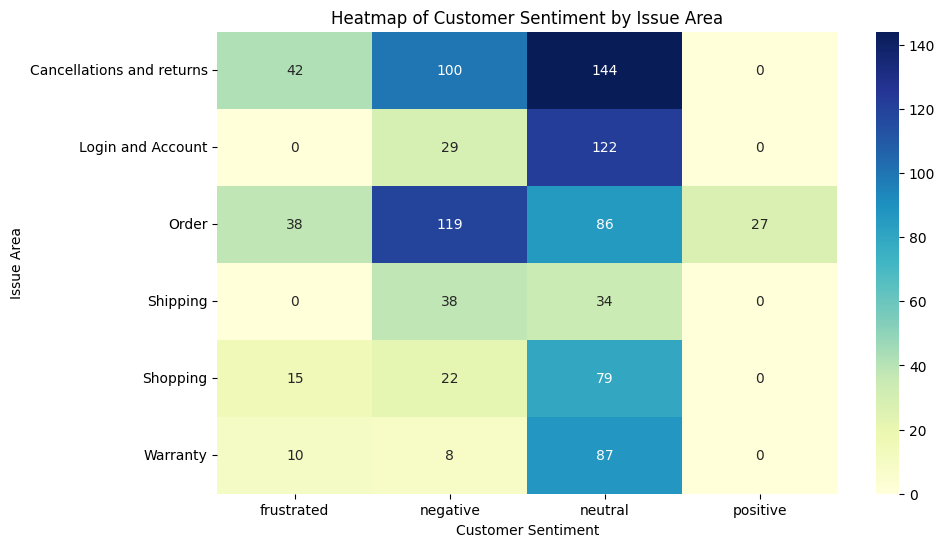

In [ ]:
# prompt: Using dataframe df: heatmap between issue area and customer sentiment

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the frequency of each customer sentiment for each issue area
sentiment_by_issue = df.groupby(['issue_area', 'customer_sentiment']).size().unstack(fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_by_issue, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Customer Sentiment by Issue Area")
plt.xlabel("Customer Sentiment")
plt.ylabel("Issue Area")
plt.show()


In [ ]:
import os
import json
import google.generativeai as genai
import time

def get_sentiment(title, chat_history):
    genai.configure(api_key="GOOGLE_API_KEY")
    model = genai.GenerativeModel("gemini-pro")

    function_schema = {
        "name": "save_sentiment",
        "description": "Save sentiment related data.",
        "parameters": {
            "type": "object",
            "properties": {
                "thought": {
                    "type": "string",
                    "description": "Your thoughts on sentence and sentiment"
                },
                "sentiment": {
                    "type": "string",
                    "description": ""
                }
            },
            "required": ["thought", "sentiment"]
        }
    }

    prompt = f"""
    You are a Support Agent. You have to decide on sentiment of the given ticket for which you are given:
    1. Title
    2. Chat History

    Follow this JSON schema strictly:
    {json.dumps(function_schema['parameters'], indent=3)}

    Examples:
    1.
    ...
    Customer: Hi, I returned a coffee maker two weeks ago, and I haven't received the refund in my bank account yet.
    Agent: I'm sorry to hear that. Can you please provide me with your order number and the bank account details that you provided for the refund?
    ...
    Sentiment: frustrated

    2.
    ...
    Customer: Hi Tom, I want a full refund for my sandwich maker. Your agent is not helping me.
    Agent: I'm sorry to hear that, Lisa. May I know the reason for the cancellation?
    Customer: I found a better deal on another website.
    ...
    Sentiment: negative

    3.
    ...
    Customer: Oh, I see. I wasn't aware of that. Is there anything I can do to get free delivery?
    Agent: I'm afraid not, but I can suggest a few options that might help you save on delivery charges.
    ...
    Sentiment: neutral

    4.
    ...
    Customer: Thanks for the quick resolution! I really appreciate the support.
    Agent: You're welcome! We're glad we could assist you. Have a great day!
    ...
    Sentiment: positive

    5.
    ...
    Customer: I need help with tracking my order. It's been delayed for a week.
    Agent: I'm sorry for the delay. Let me check the status and provide you an update shortly.
    ...
    Sentiment: frustrated

    6.
    ...
    Customer: Thanks for your assistance. I'll check the promotions and proceed with the order.
    Agent: You're welcome! Let us know if you need any further help.
    ...
    Sentiment: positive

    7.
    ...
    # The customer repeatedly complains about an unresolved issue.
    Customer: I've called multiple times about this issue, and it's still not resolved. This is getting really frustrating.
    Agent: I sincerely apologize for the repeated inconvenience. Let me escalate this to a senior representative right away.
    ...
    Sentiment: frustrated

    8.
    ...
    # The customer expresses strong dissatisfaction with service.
    Customer: Your service is the worst I've ever experienced! No one seems to care about my issue.
    Agent: I'm really sorry you feel this way. I'll do my best to address your concerns right now.
    ...
    Sentiment: frustrated

    9.
    ...
    # The customer expresses dissatisfaction but not frustration.
    Customer: I bought this phone based on your recommendation, and it’s not as good as expected.
    Agent: I apologize for the inconvenience. Could you please share what specific issues you're facing?
    ...
    Sentiment: negative

    10.
    # The customer expresses disappointment due to an unmet expectation.
    Customer: I expected faster delivery, but it took way longer than what was promised.
    Agent: I'm sorry about the delay. We will ensure quicker delivery next time.
    ...
    Sentiment: negative

    11.
    # The customer provides factual information without strong emotions.
    Customer: I need to know how to cancel my subscription before the next billing cycle.
    Agent: Sure, I can guide you through the cancellation process.
    ...
    Sentiment: neutral

    12.
    # The conversation remains informative without positive or negative tones.
    Customer: Can you please confirm if the product is available in my region?
    Agent: Let me check that for you. Could you provide your ZIP code?
    ...
    Sentiment: neutral

    13.
    # The customer expresses mild appreciation.
    Customer: The support team was helpful. Thanks for the assistance.
    Agent: Glad to hear that! Let us know if you need anything else.
    ...
    Sentiment: positive

    14.
    # The customer shows strong enthusiasm.
    Customer: I love the new update! It's exactly what I wanted.
    Agent: Thank you for your feedback! We're glad you like it.
    ...
    Sentiment: positive

    15.
    # The customer is delighted with the resolution.
    Customer: Wow! That was super fast. I really appreciate the support.
    Agent: Thank you for your kind words! We're always happy to help.
    ...
    Sentiment: positive

    16.
    # The customer feels unheard and expresses concern about communication.
    Customer: I've sent multiple emails, and no one has responded to me yet.
    Agent: I'm really sorry about that. I'll personally follow up on your request now.
    ...
    Sentiment: frustrated

    17.
    # The customer is just asking about product details without emotion.
    Customer: Does this laptop support 4K resolution?
    Agent: Yes, it supports up to 4K UHD resolution with HDR.
    ...
    Sentiment: neutral

    18.
    ...
    # The customer expresses dissatisfaction but is open to solutions.
    Customer: The software keeps crashing. I hope there's a fix for this soon.
    Agent: I'm sorry to hear that. Let me check for any available updates or troubleshooting steps.
    ...
    Sentiment: negative

    19.
    ...
    # The customer expresses gratitude after a long-standing issue is resolved.
    Customer: Finally! The issue is fixed. Thanks a ton for your patience and support.
    Agent: We're happy to help! Let us know if you need anything else.
    ...
    Sentiment: positive

    20.
    ...
    # The customer reports an issue but remains patient.
    Customer: My internet speed has been slow lately, but I understand these things happen.
    Agent: Thanks for your understanding. Let me check if there are any network issues in your area.
    ...
    Sentiment: neutral

    21.
    ...
    # The customer is angry about being misled by previous information.
    Customer: Your team told me I'd get a replacement in 3 days, but it’s been over a week!
    Agent: I sincerely apologize for the miscommunication. Let me check on your replacement order immediately.
    ...
    Sentiment: frustrated

    22.
    ...
    # The customer provides feedback in a constructive manner.
    Customer: The product works fine, but I think it could use some improvements in battery life.
    Agent: Thanks for your feedback! We'll pass it along to our development team.
    ...
    Sentiment: neutral

    23.
    ...
    # The customer is expressing mild concern about repeated issues.
    Customer: I've been facing the same problem again. Is there a permanent solution to this?
    Agent: I apologize for the recurring issue. I'll escalate this to our technical team for a thorough check.
    ...
    Sentiment: frustrated

    24.
    ...
    # The customer asks a generic question without showing emotion.
    Customer: Can you tell me your store's operating hours?
    Agent: Sure! Our store is open from 9 AM to 9 PM daily.
    ...
    Sentiment: neutral

    25.
    ...
    # The customer shows slight annoyance but remains polite.
    Customer: I was hoping to get a quicker response, but I understand you must be busy.
    Agent: Thanks for your patience! How can I assist you today?
    ...
    Sentiment: neutral

    26.
    ...
    # The customer demands a solution aggressively.
    Customer: I need this fixed RIGHT NOW! This delay is unacceptable.
    Agent: I understand your frustration. Let me prioritize your request immediately.
    ...
    Sentiment: frustrated

    27.
    ...
    # The customer expresses appreciation without strong excitement.
    Customer: Thanks, this information was helpful.
    Agent: Glad to be of assistance! Let us know if you need more help.
    ...
    Sentiment: positive

    28.
    ...
    # The customer expresses happiness after using the product.
    Customer: I must say, this is one of the best purchases I've made!
    Agent: That's wonderful to hear! Thank you for your feedback.
    ...
    Sentiment: positive

    29.
    ...
    #anything regarding refund requests are frustrating
    customer: i request a refund for the product
    Agent: I understand your frustration. Let me prioritize your request immediately.
    ...
    Sentiment: frustrated

    Title: "{title}"
    Chat History: "{chat_history}"
    """

    try:
        time.sleep(1)
        response = model.generate_content(prompt)
        sentiment_data = json.loads(response.text)
        print(sentiment_data["thought"])
        return sentiment_data["sentiment"]
    except json.JSONDecodeError:
        print("Failed to decode JSON from the model's response.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [ ]:
test_cases = [
    {
        "title": "Refund delay issue",
        "chat_history": "Customer: Hi, I returned a coffee maker two weeks ago, and I haven't received the refund in my bank account yet. Agent: I'm sorry to hear that. Can you please provide me with your order number and the bank account details?",
        "expected_sentiment": "frustrated"
    },
    {
        "title": "Product return request",
        "chat_history": "Customer: Hi Tom, I want a full refund for my sandwich maker. Your agent is not helping me. Agent: May I know the reason for the cancellation? Customer: I found a better deal on another website.",
        "expected_sentiment": "negative"
    },
    {
        "title": "Delivery charge query",
        "chat_history": "Customer: Oh, I see. I wasn't aware of that. Is there anything I can do to get free delivery? Agent: I'm afraid not, but I can suggest a few options that might help you save on delivery charges.",
        "expected_sentiment": "neutral"
    },
    {
        "title": "Order received on time",
        "chat_history": "Customer: Thanks for the fast delivery! I'm really happy with the service. Agent: We are glad you liked it! Let us know if you need any further assistance.",
        "expected_sentiment": "positive"
    }
]

# Run tests
for i, test in enumerate(test_cases, 1):
    print(f"Test Case {i}: {test['title']}")
    result = get_sentiment(test["title"], test["chat_history"])
    print(f"Predicted Sentiment: {result}")
    print(f"Expected Sentiment: {test['expected_sentiment']}")
    print("Test Passed!" if result == test["expected_sentiment"] else "Test Failed!", "\n")

Test Case 1: Refund delay issue
The customer is frustrated because they haven't received their refund yet. They returned a coffee maker two weeks ago.
Predicted Sentiment: frustrated
Expected Sentiment: frustrated
Test Passed! 

Test Case 2: Product return request
The customer is frustrated with the support provided by the agent and wants a full refund. They have found a better deal elsewhere and are not satisfied with the product.
Predicted Sentiment: negative
Expected Sentiment: negative
Test Passed! 

Test Case 3: Delivery charge query
The customer is slightly curious about the delivery charges and explores the options available for saving charges.
Predicted Sentiment: neutral
Expected Sentiment: neutral
Test Passed! 

Test Case 4: Order received on time
The customer is delighted and satisfied with the fast delivery of the order. The customer expresses an overall positive sentiment towards the service.
Predicted Sentiment: positive
Expected Sentiment: positive
Test Passed! 



In [ ]:
res = df.iloc[:100, :].apply(lambda x: get_sentiment(x["issue_category_sub_category"], x["conversation"]), axis=1)

The customer is seeking assistance with mobile number or email address verification during login, and they initially provided an incorrect mobile number. After providing the correct email address, they received the verification code successfully. The sentiment is neutral.
The customer is initially confused about being asked to ship back the monitor they purchased, but after the agent explains that it's due to a recall, they understand and appreciate the explanation of the return process. The customer is polite and cooperative throughout the conversation.
The customer is facing issues with clicking the 'Cancel' button on their account while trying to return a recently purchased product. However, the agent clarifies that it's a technical glitch and guides the customer through the replacement process instead. The customer accepts the alternative and expresses gratitude for the assistance.
The customer seemed frustrated while trying to log in to their account after failing multiple verific

An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
The customer is frustrated because they received the wrong item. The agent is apologetic and professional, and they take steps to resolve the issue by initiating a return and exchange process.
The customer was initially having trouble accessing warranty details for their camera, but with Sarah's guidance, they were able to find the necessary information on their warranty card. The customer's tone was generally positive throughout the conversation, expressing appreciation for Sarah's help. There were no strong emotions or frustrations conveyed in the chat. Overall, the conversation had a neutral sentiment.
Based on the conversation, the customer was experiencing an issue with changing the email ID associated with their BrownBox account. Throughout the conversation, the customer remained calm and 

An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
The customer wants to check the refund status on an item that they recently returned. The agent in a friendly manner confirms the refund was processed and provides further information on the timeline for the refund to reflect.
The customer started out calm and understanding but grew increasingly frustrated as the delivery delay persisted and no suitable solution could be provided until the agent offered an express shipping upgrade, which seemed to appease the customer.
The customer is returning a pair of shorts due to size issues and wants to know the return process. They acknowledge and accept the applicable return fee of $5.99. Overall, the customer's tone is neutral and the interaction is informative.
The customer is initially frustrated because they could not find invoices for previous order

An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
The customer is checking on the status of their order. The agent confirmed the order and provided an update on the shipment. The customer is satisfied with the response and ends the chat on a positive note.
The customer is experiencing issues logging into their account due to exceeding attempts to enter the correct verification code. The agent acknowledges the customer's frustration and assists by resetting their password and sending a new verification code. The issue is resolved, and the customer expresses satisfaction. Overall, the sentiment of the ticket is slightly negative at first due to the login issue but turns positive as it gets resolved.
The customer seeks assistance with scheduling a pickup for their order and receives guidance from the agent on how to do it through their account on 

An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
The customer is initially confused about the new verification requirement during login. After the agent's explanation, they understand the reason and provide the necessary information for verification. The issue with the mobile number is resolved, and the agent guides the customer for email verification as well. Overall, the conversation is positive as the customer's concerns are addressed, and the issue is resolved.
The customer, Jane Doe,  is frustrated because she was overcharged for a computer monitor. She contacted BrownBox customer support to report the issue. The agent, Max, apologized for the error and processed a refund for the overcharged amount. Jane confirmed that she won't be charged any additional fees for the refund.
The customer is expressing concern about not receiving an invoic

An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).


An error occurred: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
The customer is frustrated because of the delayed delivery of her daughter's birthday present. The agent understands the frustration and provides compensation for the inconvenience.
The customer is experiencing price discrepancies for books with the same title and is seeking assistance to resolve the issue. The agent acknowledges the issue and escalates it to the senior team for further investigation and resolution. The customer provides necessary information and contact details for follow-up. Overall, the sentiment is neutral, as the customer is not expressing strong emotions but rather reporting a problem and seeking a solution.


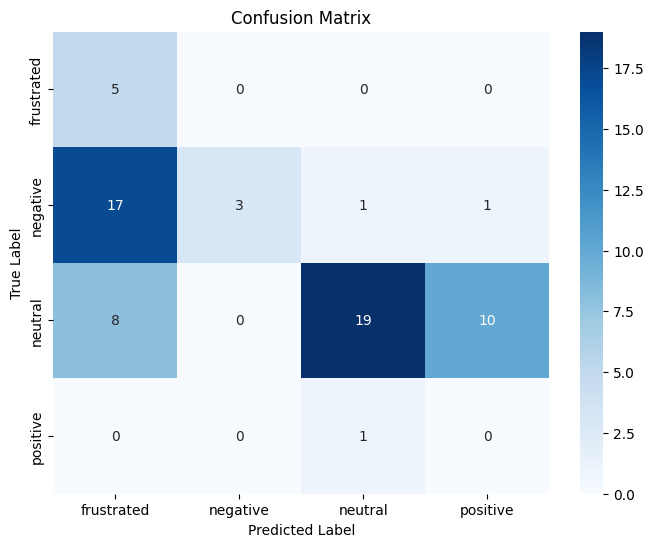

In [ ]:
# prompt: make 4x4 confusion matrix using df["customer_sentiment"] and res, they have these possible values: 'neutral', 'negative', 'frustrated', 'positive'

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df["customer_sentiment"]' and 'res' are already defined
# and contain the predicted and true sentiment labels, respectively.

# Ensure both series have the same length
min_len = min(len(df["customer_sentiment"]), len(res))
y_true = df["customer_sentiment"][:min_len]
y_pred = res[:min_len]

# Define the possible sentiment labels
labels = ['frustrated', 'negative', 'neutral', 'positive']

# Filter out None values from y_pred and corresponding y_true
valid_indices = y_pred.notna()  # Create a boolean mask for non-None values
y_true = y_true[valid_indices]  # Filter y_true using the mask
y_pred = y_pred[valid_indices]  # Filter y_pred using the mask
y_pred = y_pred.astype(str)  # Convert y_pred to string type


# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# prompt: calculate f1 score for every 'customer_sentiment' category

from sklearn.metrics import f1_score

# Assuming 'df["customer_sentiment"]' and 'res' are already defined
# and contain the predicted and true sentiment labels, respectively.

# Ensure both series have the same length
min_len = min(len(df["customer_sentiment"]), len(res))
y_true = df["customer_sentiment"][:min_len]
y_pred = res[:min_len]

# Define the possible sentiment labels
labels = ['frustrated',  'negative', 'neutral', 'positive']

# Filter out None values from y_pred and corresponding y_true
valid_indices = y_pred.notna()  # Create a boolean mask for non-None values
y_true = y_true[valid_indices]  # Filter y_true using the mask
y_pred = y_pred[valid_indices]  # Filter y_pred using the mask
y_pred = y_pred.astype(str)  # Convert y_pred to string type

# Calculate the F1 score for each label
for label in labels:
    # Filter out instances where y_true or y_pred is not in 'labels'
    mask = y_true.isin(labels) & y_pred.isin(labels)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) > 0 and len(y_pred_filtered) > 0:  # Check if filtered arrays are not empty
        f1 = f1_score(y_true_filtered, y_pred_filtered, average=None, labels=[label])
        print(f"F1 score for {label}: {f1[0]}")
    else:
        print(f"F1 score for {label}: Not enough data to calculate")

# Calculate the macro-average F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro', labels=labels)  # Include 'labels'
print(f"\nMacro-average F1 score: {macro_f1}")

# Calculate the weighted-average F1 score
weighted_f1 = f1_score(y_true, y_pred, average='weighted', labels=labels)  # Include 'labels'
print(f"Weighted-average F1 score: {weighted_f1}")

F1 score for frustrated: 0.2857142857142857
F1 score for negative: 0.24
F1 score for neutral: 0.6551724137931034
F1 score for positive: 0.0

Macro-average F1 score: 0.29522167487684725
Weighted-average F1 score: 0.47615308829101927


In [ ]:
"""
F1 score for frustrated: 0.36363636363636365
F1 score for negative: 0.2631578947368421
F1 score for neutral: 0.45569620253164556
F1 score for positive: 0.04878048780487805

Macro-average F1 score: 0.28281773717743236
Weighted-average F1 score: 0.3765795292257325

---------------------------------------------------

F1 score for frustrated: 0.5
F1 score for negative: 0.2222222222222222
F1 score for neutral: 0.5753424657534246
F1 score for positive: 0.06060606060606061

Macro-average F1 score: 0.33954268714542685
Weighted-average F1 score: 0.4326214965484372

---------------------------------------------------
F1 score for frustrated: 0.2926829268292683
F1 score for negative: 0.05555555555555555
F1 score for neutral: 0.6987951807228916
F1 score for positive: 0.0

Macro-average F1 score: 0.2617584157769288
Weighted-average F1 score: 0.4179663962576099
"""

'\nF1 score for frustrated: 0.36363636363636365\nF1 score for negative: 0.2631578947368421\nF1 score for neutral: 0.45569620253164556\nF1 score for positive: 0.04878048780487805\n\nMacro-average F1 score: 0.28281773717743236\nWeighted-average F1 score: 0.3765795292257325\n\n---------------------------------------------------\n\nF1 score for frustrated: 0.5\nF1 score for negative: 0.2222222222222222\nF1 score for neutral: 0.5753424657534246\nF1 score for positive: 0.06060606060606061\n\nMacro-average F1 score: 0.33954268714542685\nWeighted-average F1 score: 0.4326214965484372\n\n---------------------------------------------------\nF1 score for frustrated: 0.2926829268292683\nF1 score for negative: 0.05555555555555555\nF1 score for neutral: 0.6987951807228916\nF1 score for positive: 0.0\n\nMacro-average F1 score: 0.2617584157769288\nWeighted-average F1 score: 0.4179663962576099\n'

In [ ]:
# prompt: define preprocess_text for next code

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # # Lemmatize the tokens
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return " ".join(tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
fdf = df.loc[df["customer_sentiment"].eq("frustrated"), :]
ngdf = df.loc[df["customer_sentiment"].eq("negative"), :]
ndf = df.loc[df["customer_sentiment"].eq("neutral"), :]
pdf = df.loc[df["customer_sentiment"].eq("positive"), :]

# fdf_refund = fdf.loc[fdf["conversation"].str.lower().str.contains("refund"), :]
# ndf_refund = ndf.loc[ndf["conversation"].str.lower().str.contains("refund"), :]

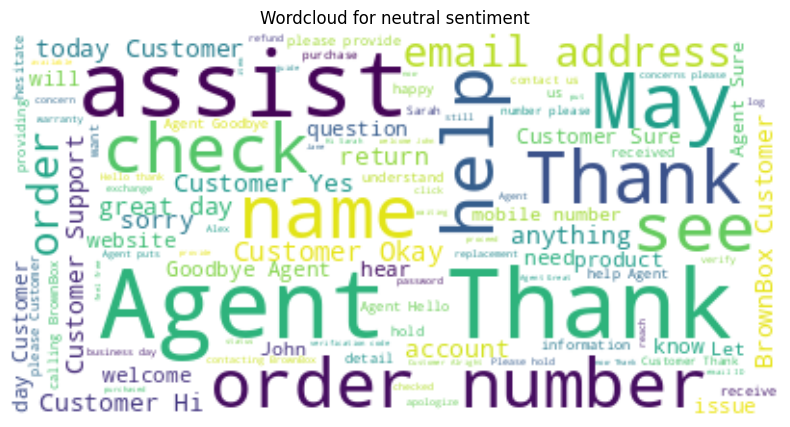

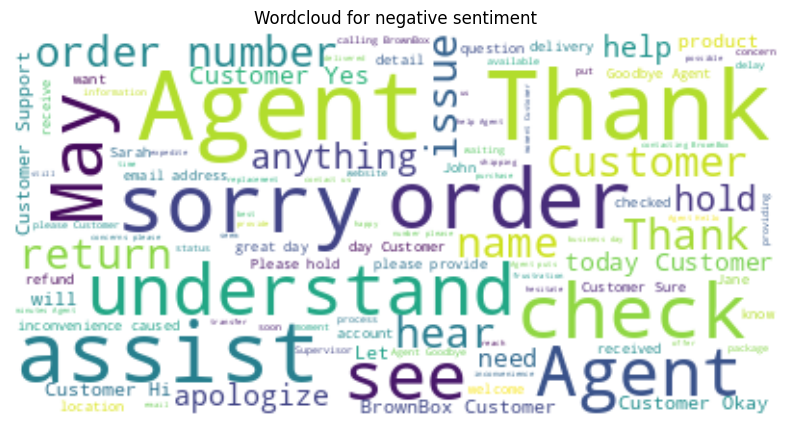

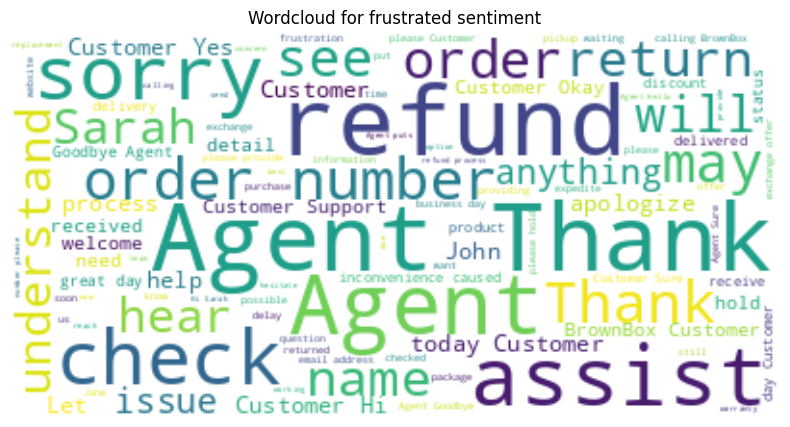

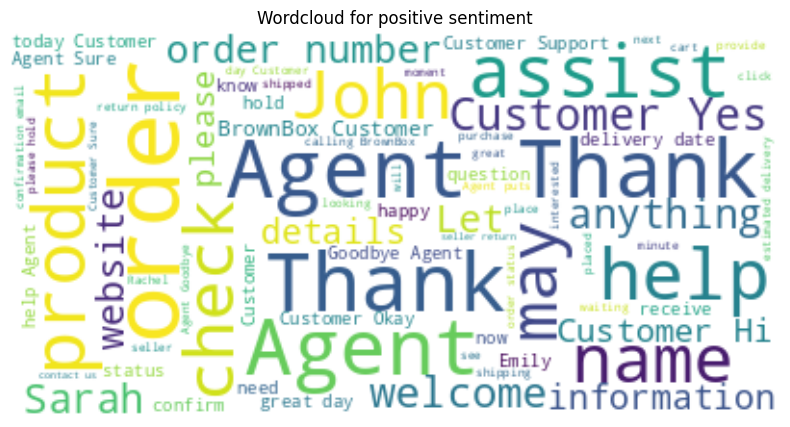

In [ ]:
# prompt: for every sentiment category, make a category df and plot wordplot for 'conversation' column, after removing stop words

import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Assuming df and the preprocessing function are defined as in your original code
# ... (your existing code)

# Assuming 'df' is your DataFrame with a 'customer_sentiment' and 'conversation' columns

for sentiment in df['customer_sentiment'].unique():
    sentiment_df = df[df['customer_sentiment'] == sentiment]

    # Combine all conversation texts for this sentiment category
    all_conversations = " ".join(sentiment_df['conversation'].astype(str))  # Convert to string for concatenation

    # Preprocess the combined conversation text (remove stop words, lemmatize)
    preprocessed_text = preprocess_text(all_conversations)

    # Plot the wordcloud
    plot_wordcloud(all_conversations, f"Wordcloud for {sentiment} sentiment")

In [ ]:
print(ngdf["conversation"].sample(n=1).values[0])

Agent: Hello, thank you for calling BrownBox Customer Support. My name is Kate, how may I assist you today?

Customer: Hi, I have a complaint about the vacuum cleaner I received from your company.

Agent: I'm sorry to hear that, can you please provide me with your order number and the issue you're facing?

Customer: My order number is 12345, and the vacuum cleaner I received is not functioning correctly. I want to return it and get a replacement as soon as possible.

Agent: I'm sorry for the inconvenience caused. Let me check your order details. Can you please hold on for a moment?

(Customer is on hold for a couple of minutes)

Agent: Thank you for holding, I checked your order details, and I can see that you're eligible for a return and replacement. Can you please confirm the reason for the return?

Customer: The vacuum cleaner is not functioning correctly, and I'm not satisfied with the product.

Agent: I understand your concern. We apologize for the inconvenience caused. Let me gui

In [ ]:
print(ndf["conversation"].sample(n=1).values[0])

Agent: Hello, thank you for contacting BrownBox customer support. My name is Emily, how may I assist you today?

Customer: Hi Emily, I purchased a printer from your website, and I noticed that the warranty terms on the website are different from the ones on the physical warranty card that came with the printer. I am not sure which one to follow.

Agent: I'm sorry to hear that, and I understand your confusion. May I please have your order number and registered email address so that I can check the details and assist you further?

Customer: Sure, my order number is BB987654, and my registered email address is janedoe@email.com.

Agent: Thank you, Jane. I can see that you purchased a printer from us, and I apologize for the confusion regarding the warranty terms. Let me quickly check the details and see what we can do to resolve this issue.

(Customer is put on hold for a minute)

Agent: Thank you for your patience, Jane. I have checked the details, and I see that there is a mismatch betw